In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import pandas as pd
import numpy as np
import pylab as plt
import LOB_analysis  #helper functions for loading data

In [4]:
base_directory = './AMD/'
msg_file = 'AMD/AMD_2020-01-02_24900000_57900000_message_10.csv'
order_book = 'AMD/AMD_2020-01-02_24900000_57900000_orderbook_10.csv'

message = LOB_analysis.load_message(base_directory + msg_file).reset_index()
LOB = LOB_analysis.load_LOB(base_directory + order_book).reset_index()

In [5]:
pd.read_csv(base_directory + msg_file)

,12713.562747076,7,0,0.1,1,-1,null
0,14400.121165,1,42733,5000,461200,1,NaN
1,14417.503762,1,97513,60,500800,-1,NaN
2,14418.843253,1,97665,100,461100,1,NaN
3,14418.843425,1,97669,100,461300,1,NaN
4,14419.111858,1,97749,100,500700,-1,NaN
...,...,...,...,...,...,...,...
1425990,72000.097562,3,275856537,33,494000,1,NaN
1425991,72000.097562,3,270414921,12500,475000,1,NaN
1425992,72000.097612,3,273083725,10000,452000,1,NaN
1425993,72000.097615,3,271728433,10000,349000,1,NaN


In [6]:
message

,index,time,type,id,vol,price,direct
0,0,12713.562747,7,0,0,1,-1
1,1,14400.121165,1,42733,5000,461200,1
2,2,14417.503762,1,97513,60,500800,-1
3,3,14418.843253,1,97665,100,461100,1
4,4,14418.843425,1,97669,100,461300,1
...,...,...,...,...,...,...,...
1425991,1425991,72000.097562,3,275856537,33,494000,1
1425992,1425992,72000.097562,3,270414921,12500,475000,1
1425993,1425993,72000.097612,3,273083725,10000,452000,1
1425994,1425994,72000.097615,3,271728433,10000,349000,1


In [7]:
message["time"]

0          12713.562747
1          14400.121165
2          14417.503762
3          14418.843253
4          14418.843425
               ...     
1425991    72000.097562
1425992    72000.097562
1425993    72000.097612
1425994    72000.097615
1425995    72000.097626
Name: time, Length: 1425996, dtype: float64

In [8]:
t0 = 10.00 # time expressed in hours
t1 = 15.00 # time
time_indices_bool = (message["time"] >= t0*3600) & (message["time"] < t1*3600)
time_indices = np.arange(len(LOB))[time_indices_bool]

In [9]:
len(time_indices)

998955

In [10]:
np.random.seed(127)
n =100000
sample_time_indices = np.random.randint(min(time_indices), max(time_indices), size = n)
sample_time_indices.sort()
sample_time_indices

array([ 157221,  157221,  157233, ..., 1156139, 1156157, 1156167])

# mid price

In [11]:
mid_price = (LOB[f"ask_price_{1}"].values + LOB[f"bid_price_{1}"].values)/2.

In [12]:
LOB.head()

,index,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0,9999999999,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
1,1,9999999999,0,461200,5000,9999999999,0,-9999999999,0,9999999999,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
2,2,500800,60,461200,5000,9999999999,0,-9999999999,0,9999999999,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
3,3,500800,60,461200,5000,9999999999,0,461100,100,9999999999,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
4,4,500800,60,461300,100,9999999999,0,461200,5000,9999999999,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0


# Smoothing labelling method
k = 20
alpha = 0.4

In [16]:
k = 50
previous = []
future = []
sample_mid = []
for i in range(len(sample_time_indices)):
    t = sample_time_indices[i]
    previous.append(np.sum(mid_price[t-(k-1): t+1], dtype=np.float32))
    future.append(np.sum(mid_price[t+1: t+k+1], dtype=np.float32))
    sample_mid.append(mid_price[t+1])


In [17]:
direction = np.zeros(len(sample_time_indices))
up_indices = np.arange(len(sample_time_indices))[np.array(future) > np.array(previous)]
down_indices = np.arange(len(sample_time_indices))[np.array(future) < np.array(previous)]
direction[up_indices] = 1
direction[down_indices] = 2
cat_direction = to_categorical(direction, 3)

In [18]:
np.sum(direction==0)/len(previous)

0.43684

Text(0, 0.5, 'mid price level')

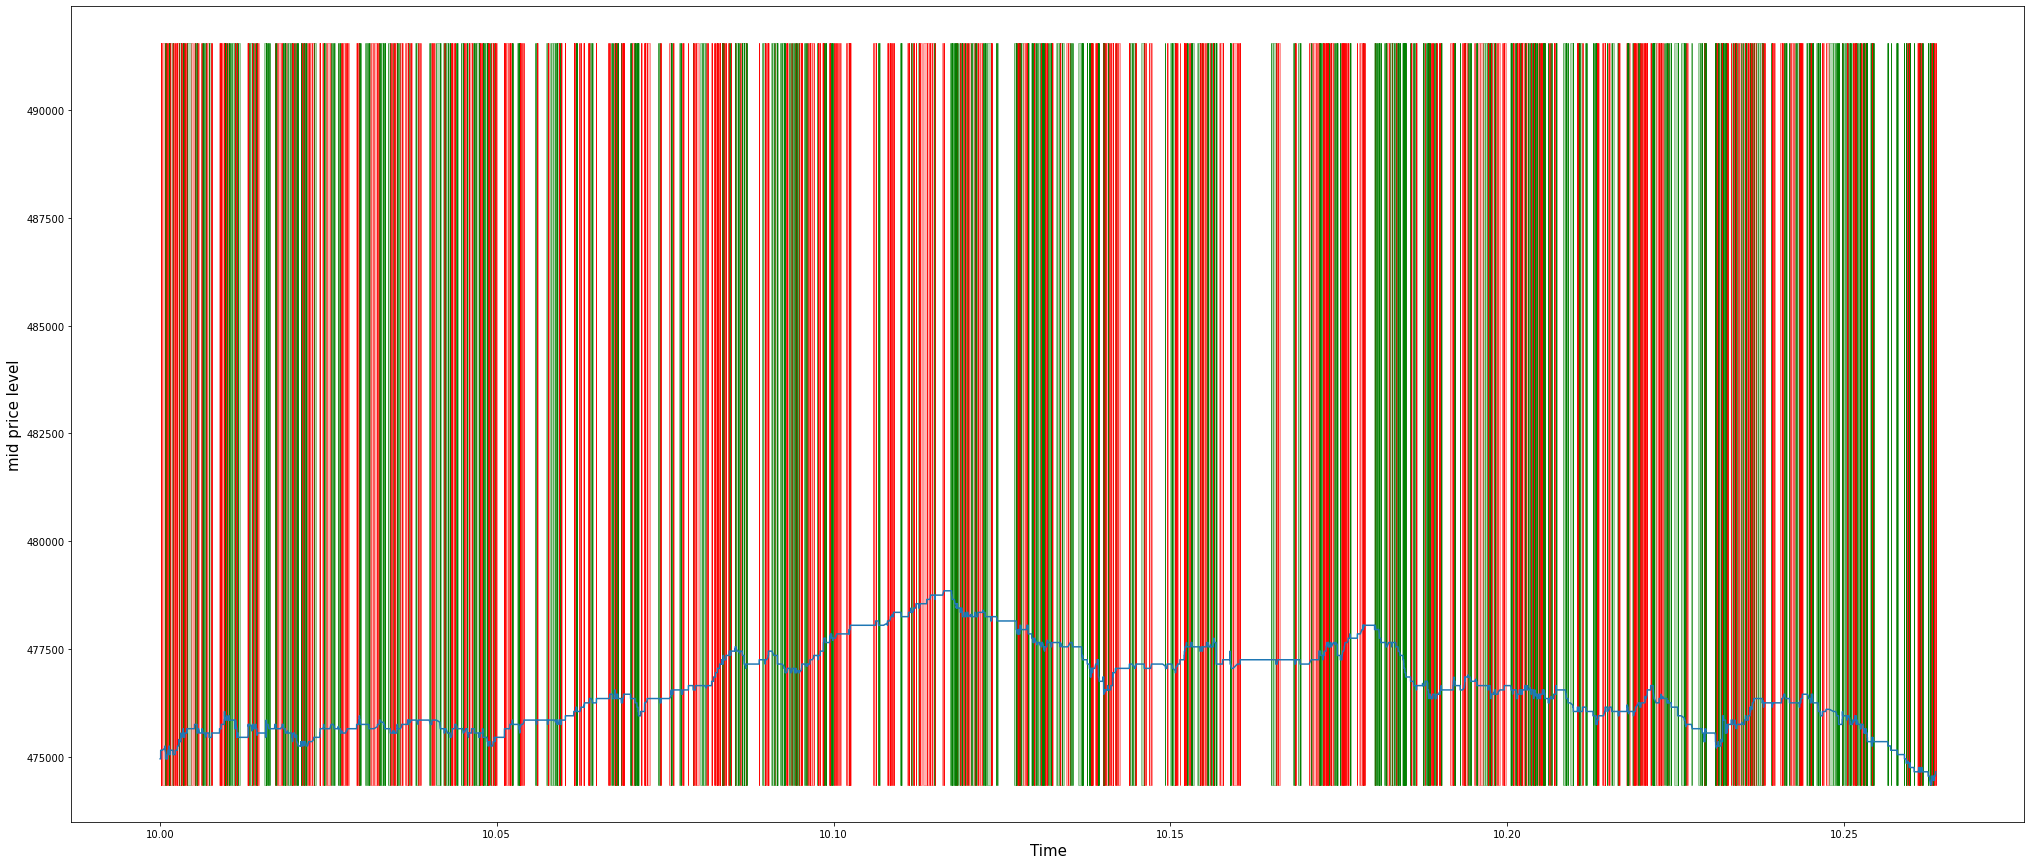

In [40]:
n =10000
plt.figure(figsize=(35,15))
plt.plot(message.time.values[sample_time_indices][:n]/3600., sample_mid[:n])  
range_min = min(sample_mid)-0.05
range_max = max(sample_mid)+0.05

for i in range(n-1):
    ind = sample_time_indices[i]
    next_ind = sample_time_indices[i+1]
    if direction[i] == 2:
        plt.fill_between([message.time[ind] / 3600.,message.time[next_ind] / 3600.],
                 range_min, range_max, color = "green", alpha = 0.3)
    elif direction[i] == 1:
        plt.fill_between([message.time[ind] / 3600.,message.time[next_ind] / 3600.],
                 range_min,range_max, color = "red", alpha = 0.3)
    
plt.xlabel("Time", fontsize=15)
plt.ylabel("mid price level", fontsize=15)

# volume imbalance
(v_ask - v_bid)/(v_ask+v_bid)

In [17]:
data = LOB.iloc[sample_time_indices, ]
volumn_ask = data.apply(lambda x: np.sum(x[range(2, 41, 4)]), axis=1)
volumn_bid = data.apply(lambda x: np.sum(x[range(4, 41, 4)]), axis=1)

In [13]:
volumn_imbalance = (volumn_ask - volumn_bid)/(volumn_ask+volumn_bid)

Text(0, 0.5, 'volume imbalance')

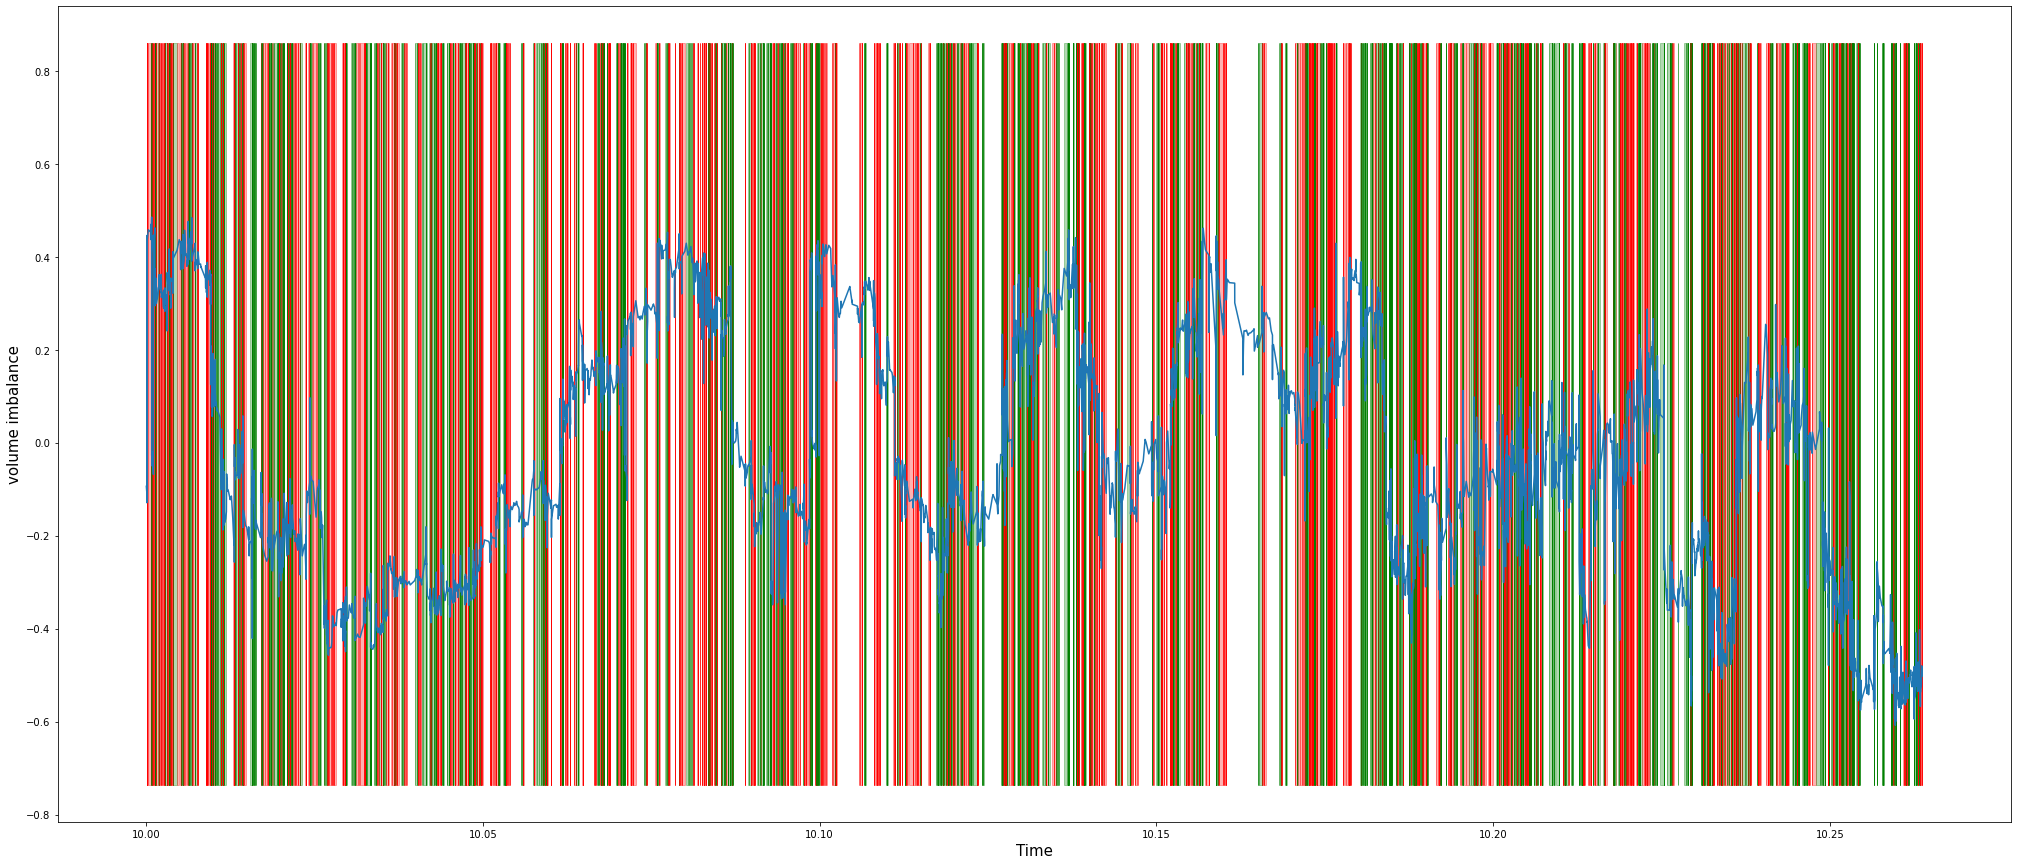

In [14]:
n = 10000
plt.figure(figsize=(35,15))
plt.plot(message.time.values[sample_time_indices][:n]/3600., volumn_imbalance[:n])  
range_min = min(volumn_imbalance)-0.05
range_max = max(volumn_imbalance)+0.05

for i in range(n-1):
    ind = sample_time_indices[i]
    next_ind = sample_time_indices[i+1]
    if direction[i] == 2:
        plt.fill_between([message.time[ind] / 3600.,message.time[next_ind] / 3600.],
                 range_min, range_max, color = "green", alpha = 0.3)
    elif direction[i] == 1:
        plt.fill_between([message.time[ind] / 3600.,message.time[next_ind] / 3600.],
                 range_min,range_max, color = "red", alpha = 0.3)
    
plt.xlabel("Time", fontsize=15)
plt.ylabel("volume imbalance", fontsize=15)

# train validation test split: 60-20-20

In [28]:
ask_prices = LOB.iloc[sample_time_indices, :]["ask_price_1"]
bid_prices = LOB.iloc[sample_time_indices, :]["bid_price_1"]

In [29]:
train_time_indices = sample_time_indices[:int(0.6*len(sample_time_indices))]
validation_time_indices = sample_time_indices[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
test_time_indices = sample_time_indices[int(0.8*len(sample_time_indices)):]

train_ask_prices = ask_prices[:int(0.6*len(sample_time_indices))]
train_bid_prices = bid_prices[:int(0.6*len(sample_time_indices))]
train_vol_im = volumn_imbalance[:int(0.6*len(sample_time_indices))]
train_y = cat_direction[:int(0.6*len(sample_time_indices))]
train_x = pd.DataFrame([train_ask_prices.values, train_bid_prices.values, train_vol_im.values]).T

In [ ]:
validation_ask_prices = ask_prices[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
validation_bid_prices = bid_prices[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
validation_vol_im = volumn_imbalance[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
validation_y = cat_direction[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
validation_x = pd.DataFrame([validation_ask_prices.values, validation_bid_prices.values, validation_vol_im.values]).T

In [16]:
test_time_indices = sample_time_indices[int(0.8*len(sample_time_indices)):]
test_ask_prices = ask_prices[int(0.8*len(sample_time_indices)):]
test_bid_prices = bid_prices[int(0.8*len(sample_time_indices)):]
test_vol_im = volumn_imbalance[int(0.8*len(sample_time_indices)):]
test_y = cat_direction[int(0.8*len(sample_time_indices)):]
test_x = pd.DataFrame([test_ask_prices.values, test_bid_prices.values, test_vol_im.values]).T

NameError: name 'ask_prices' is not defined

In [105]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)
s_train_x = scaler.transform(train_x)
s_validation_x = scaler.transform(validation_x)
s_test_x = scaler.transform(test_x)

In [75]:
s_train_x.shape

(60000, 3)

### Logistic regression
- input size: 3
- output size: 3

In [109]:
#one softmax layer
model_3x3 = Sequential([Dense(3, input_shape=(3,)),
                                   Activation('softmax'),
                                  ])

In [110]:
model_3x3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],)

In [112]:
model_3x3.fit(s_train_x, train_y, 
              epochs = 20, 
              batch_size = 32,
              validation_data=(s_validation_x, validation_y),
              callbacks=[EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience = 5)])

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 1.0997 - accuracy: 0.4268 - val_loss: 1.0959 - val_accuracy: 0.5159
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0586 - accuracy: 0.4438 - val_loss: 1.1059 - val_accuracy: 0.5159
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0585 - accuracy: 0.4433 - val_loss: 1.0883 - val_accuracy: 0.5159
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0585 - accuracy: 0.4434 - val_loss: 1.0901 - val_accuracy: 0.5159
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0584 - accuracy: 0.4440 - val_loss: 1.1080 - val_accuracy: 0.5159
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0584 - accuracy: 0.4432 - val_loss: 1.0850 - val_accuracy: 0.5159
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0583 - accuracy: 0.4451 - val_loss: 1.0819 - val_accuracy:

In [114]:
model_3x3.evaluate(s_test_x, test_y)

625/625 [==============================] - 1s 1ms/step - loss: 1.6138 - accuracy: 0.3808


[1.6137959957122803, 0.3808499872684479]

- input size: 3
- output size: 3

### use 40 input variables
- bid price *10, bid volume * 10, ask price * 10, ask volume * 10

In [115]:
train_x_40 = data[:int(0.6*len(sample_time_indices))].iloc[:, 1:]
validation_x_40 = data[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))].iloc[:, 1:]
test_x_40 = data[int(0.8*len(sample_time_indices)):].iloc[:, 1:]

scaler_40 = StandardScaler()
scaler_40 = scaler_40.fit(train_x_40)

s_train_x_40 = scaler_40.transform(train_x_40)
s_validation_x_40 = scaler_40.transform(validation_x_40)
s_test_x_40 = scaler_40.transform(test_x_40)

In [124]:
model_40 = Sequential([Dense(3, input_shape=(40,)),
                                   Activation('softmax'),
                                  ])

In [125]:
model_40.compile(optimizer = "adam",
              loss = 'categorical_crossentropy',
              metrics =['accuracy'])

In [126]:
model_40.fit(s_train_x_40, train_y, 
             epochs = 40, batch_size = 32,
             validation_data=(s_validation_x_40, validation_y),
             callbacks=[EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience = 5)])

Epoch 1/40
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0490 - accuracy: 0.4869 - val_loss: 1.0705 - val_accuracy: 0.5034
Epoch 2/40
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0125 - accuracy: 0.5088 - val_loss: 1.0865 - val_accuracy: 0.5052
Epoch 3/40
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0119 - accuracy: 0.5089 - val_loss: 0.9848 - val_accuracy: 0.5066
Epoch 4/40
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0111 - accuracy: 0.5116 - val_loss: 1.0120 - val_accuracy: 0.5070
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0107 - accuracy: 0.5127 - val_loss: 1.0518 - val_accuracy: 0.5112
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0100 - accuracy: 0.5140 - val_loss: 0.9876 - val_accuracy: 0.5257
Epoch 7/40
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0099 - accuracy: 0.5140 - val_loss: 0.9802 - val_accuracy:

In [127]:
model_40.evaluate(s_test_x_40, test_y)

625/625 [==============================] - 1s 2ms/step - loss: 1.3621 - accuracy: 0.3823


[1.3621340990066528, 0.38225001096725464]

### DNN

In [128]:
model_dnn = Sequential([
    Dense(10, input_shape=(40, )),
    Activation('relu'),
    Dense(5, ),
    Activation('relu'),
    Dense(5, ),
    Activation('relu'),
    Dense(3, ),
    Activation('softmax'),
    
])

In [129]:
model_dnn.compile(optimizer = "adam",
              loss = 'categorical_crossentropy',
              metrics =['accuracy'])

In [130]:
model_dnn.fit(s_train_x_40, train_y, 
             epochs = 40, batch_size = 32,
             validation_data=(s_validation_x_40, validation_y),
             callbacks=[EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience = 5)])

Epoch 1/40
1875/1875 [==============================] - 5s 2ms/step - loss: 1.0161 - accuracy: 0.4842 - val_loss: 0.9437 - val_accuracy: 0.5507
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9569 - accuracy: 0.5380 - val_loss: 0.9316 - val_accuracy: 0.5427
Epoch 3/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9423 - accuracy: 0.5472 - val_loss: 0.9163 - val_accuracy: 0.5566
Epoch 4/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9329 - accuracy: 0.5539 - val_loss: 0.9427 - val_accuracy: 0.5339
Epoch 5/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9259 - accuracy: 0.5604 - val_loss: 0.9274 - val_accuracy: 0.5558
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9208 - accuracy: 0.5649 - val_loss: 0.9494 - val_accuracy: 0.5504
Epoch 7/40
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9167 - accuracy: 0.5699 - val_loss: 0.9485 - val_accuracy:

In [138]:
 model_dnn.evaluate(s_test_x_40, test_y)

625/625 [==============================] - 1s 2ms/step - loss: 1.4023 - accuracy: 0.4031


[1.402273178100586, 0.4030500054359436]

## choose the best k for input(current)

In [145]:
loss = []
accuracy = []

for k in range(0, 71, 10):
    if k==0:
        continue
    # prepare the input
    input_k_mean = np.ndarray(shape = (100000, 2, 40), dtype=float)
    for i in range(len(sample_time_indices)):
        t = sample_time_indices[i]
        input_k_mean[i][0] = LOB.iloc[t, ].values[1:]
        input_k_mean[i][1] = np.mean(LOB.iloc[t-k:t, ].values[:, 1:])
    
    #split and standardise train validation and test (60-20-20)
    train_x_k_mean = input_k_mean[:int(0.6*len(sample_time_indices))]
    validation_x_k_mean = input_k_mean[int(0.6*len(sample_time_indices)):int(0.8*len(sample_time_indices))]
    test_x_k_mean = input_k_mean[int(0.8*len(sample_time_indices)):]
    
    scaler_k_mean = StandardScaler()
    s_train_x_k_mean = scaler_k_mean.fit_transform(train_x_k_mean.reshape(train_x_k_mean.shape[0], -1))
    s_validation_x_k_mean = scaler_k_mean.transform(validation_x_k_mean.reshape(validation_x_k_mean.shape[0], -1))
    s_test_x_k_mean = scaler_k_mean.transform(test_x_k_mean.reshape(test_x_k_mean.shape[0], -1))
    
    #build logistic
    model_dnn_k_mean = Sequential([Dense(3, input_shape=(80,)),
                                   Activation('softmax'),
                                  ])
    
    model_dnn_k_mean.compile(optimizer = "adam",
              loss = 'categorical_crossentropy',
              metrics =['accuracy'])
    
    model_dnn_k_mean.fit(s_train_x_k_mean, train_y, 
             epochs = 1000, batch_size = 32,
             validation_data=(s_validation_x_k_mean, validation_y),
             callbacks=[EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience = 30)])
    l, a = model_dnn_k_mean.evaluate(s_test_x_k_mean, test_y)
    print(f"k={k}  loss = {l}   accuracy={a}")
    model_dnn_k_mean.save(f'model_k{k}.h5')
    loss.append(l)
    accuracy.append(a)

Epoch 1/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0435 - accuracy: 0.4853 - val_loss: 1.0162 - val_accuracy: 0.5061
Epoch 2/1000
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0160 - accuracy: 0.5027 - val_loss: 1.0059 - val_accuracy: 0.5033
Epoch 3/1000
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0154 - accuracy: 0.5055 - val_loss: 0.9891 - val_accuracy: 0.5225
Epoch 4/1000
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0141 - accuracy: 0.5091 - val_loss: 1.0201 - val_accuracy: 0.5052
Epoch 5/1000
1875/1875 [==============================] - 2s 986us/step - loss: 1.0133 - accuracy: 0.5075 - val_loss: 1.0327 - val_accuracy: 0.5258
Epoch 6/1000
1875/1875 [==============================] - 2s 962us/step - loss: 1.0129 - accuracy: 0.5100 - val_loss: 1.0212 - val_accuracy: 0.5127
Epoch 7/1000
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0122 - accuracy: 0.5083 - val_loss: 1.10

In [146]:
loss

[1.8030757904052734,
 1.1867127418518066,
 1.3990743160247803,
 1.265724778175354,
 1.2398710250854492,
 1.7255789041519165,
 1.5421088933944702]

In [147]:
accuracy 

[0.38269999623298645,
 0.4449000060558319,
 0.4176500141620636,
 0.4203999936580658,
 0.4194999933242798,
 0.3856000006198883,
 0.42100000381469727]